In [1]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from src import customFunc as cf
from src import ansatzs as anz

In [2]:
# Hamiltonians
with open(f"data/hamiltonian{0.719}.pkl", "rb") as f:
    hamiltonian = pickle.load(f)
# Repulsion energies
with open(f"data/nuclear_repulsion{0.719}.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

In [63]:
ansatz_opt=anz.optimize_qaoa(hamiltonian)
ansatz_opt.draw('mpl')

TranspilerError: "HighLevelSynthesis was unable to synthesize Instruction(name='u', num_qubits=1, num_clbits=0, params=[0, 0, -1.5707963267948966])."

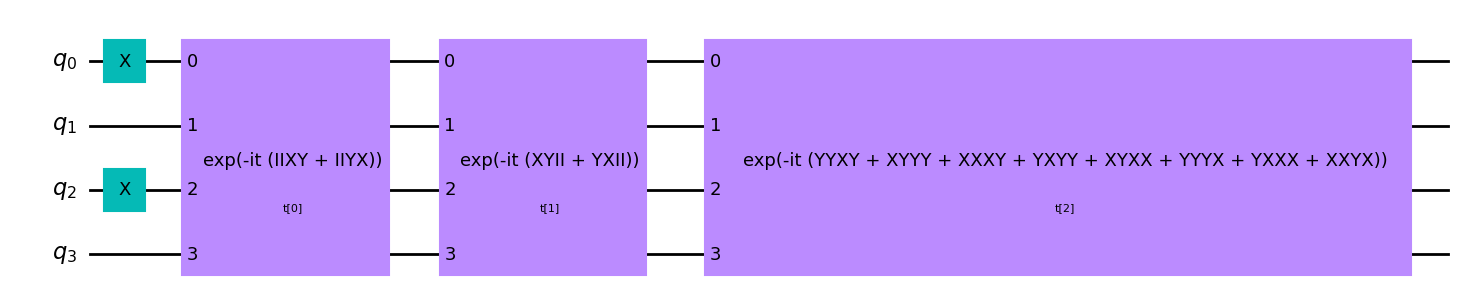

In [96]:
with open(f"data/ansatz0.719.pkl", "rb") as f:
    ansatz_naive = pickle.load(f)
ansatz_naive.decompose().draw('mpl')

In [4]:
print(hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80508703+0.j,  0.17468284+0.j, -0.23335742+0.j,  0.17468284+0.j,
 -0.23335742+0.j,  0.12183444+0.j,  0.16969102+0.j,  0.16684527+0.j,
  0.04501083+0.j,  0.04501083+0.j,  0.04501083+0.j,  0.04501083+0.j,
  0.16684527+0.j,  0.17538577+0.j,  0.12183444+0.j])


In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (HighLevelSynthesis, InverseCancellation)
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (SwapStrategy, FindCommutingPauliEvolutions, Commuting2qGateRouter)
from qiskit.circuit.library import CXGate

In [6]:
def is_two_qubits(pauli_string):
    """Function that returns an operator if it acts on 2 qubits"""
    return pauli_string.count('I') == len(pauli_string) - 1

def optimize_qaoa(cost_operator):
    # Separate 2 qubit gates from other gates
    pauli_list = cost_operator.to_list()
    two_qubits = [(p, c) for p, c in pauli_list if not is_two_qubits(p)]
    others    = [(p, c) for p, c in pauli_list if is_two_qubits(p)]
    cost_2qubits = SparsePauliOp.from_list(two_qubits)
    cost_other = SparsePauliOp.from_list(others)

    # Choose swap strategy (in this case -> line)
    num_qubits=cost_operator.num_qubits
    swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
    edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

    # Define pass manager
    init_cost_layer = PassManager([HighLevelSynthesis(basis_gates=['PauliEvolution']), FindCommutingPauliEvolutions(), Commuting2qGateRouter(swap_strategy, edge_coloring,), HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]), InverseCancellation(gates_to_cancel=[CXGate()])])

    # Create a circuit for the 2 qubit gates and optimize it with the cost layer pass manager
    qaoa_2qubits = QAOAAnsatz(cost_operator=cost_2qubits, reps=1, initial_state=QuantumCircuit(num_qubits), mixer_operator=QuantumCircuit(num_qubits))
    qaoa_2qubits_opt=init_cost_layer.run(qaoa_2qubits)

    return qaoa_2qubits_opt

In [165]:
from qiskit.transpiler.passes import (
    UnrollCustomDefinitions,
    BasisTranslator,
)

from qiskit.circuit.equivalence_library import StandardEquivalenceLibrary

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import time
from qiskit.providers.fake_provider import FakeManila

backend = FakeManila()

Transpilation time: 0.029662609100341797 (s)
Circuit info: OrderedDict([('cx', 19), ('rz', 13), ('sx', 5)])
Depth: 29


c:\Anaconda\envs\qiskitTFM\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


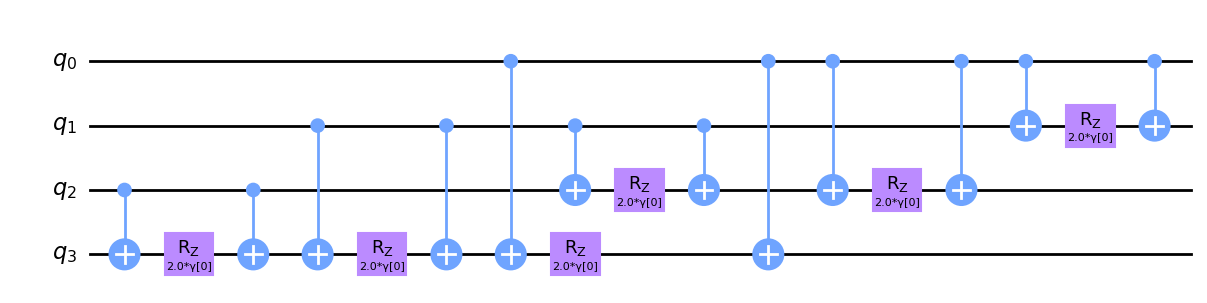

In [176]:
num_qubits=4
a=SparsePauliOp(['ZZII','ZIZI','ZIIZ','IZZI','IZIZ','IIZZ'])
qaoa_2qubits = QAOAAnsatz(cost_operator=a, reps=1, initial_state=QuantumCircuit(num_qubits), mixer_operator=QuantumCircuit(num_qubits))
#qaoa_2qubits=ansatz_naive
basis_gates = ['rx', 'rz', 'cx', 'h']
# 1. Configura el PassManager
pm = PassManager([
    # 1. Desenrolla definiciones personalizadas
    UnrollCustomDefinitions(StandardEquivalenceLibrary, basis_gates),  
    # 2. Traduce a las puertas base
    BasisTranslator(StandardEquivalenceLibrary, target_basis=basis_gates),
])

# 2. Aplica al circuito
qaoa_2qubits = pm.run(qaoa_2qubits)

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
opt_transpiled_qaoa = pm.run(qaoa_2qubits)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {opt_transpiled_qaoa.count_ops()}')
print(f'Depth: {opt_transpiled_qaoa.depth()}')

display(qaoa_2qubits.draw('mpl'))

Transpilation time: 0.04627633094787598 (s)
Circuit info: OrderedDict([('cx', 19), ('rz', 13), ('sx', 5)])
Depth: 29


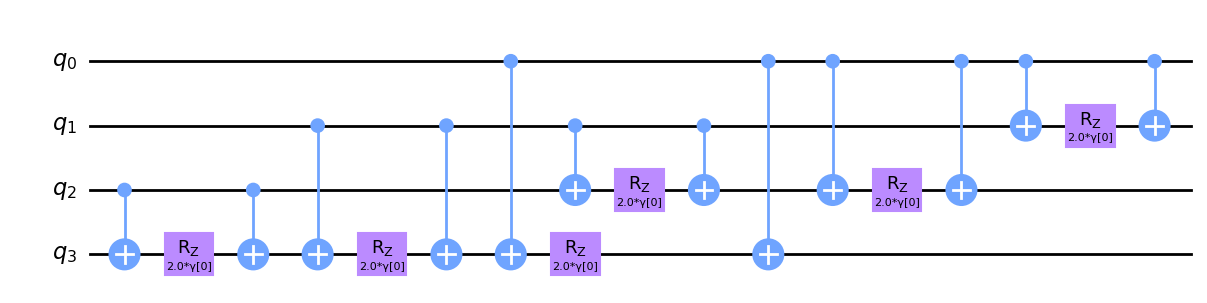

In [183]:
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# Define pass manager
init_cost_layer = PassManager([HighLevelSynthesis(basis_gates=["PauliEvolution", "cx", "rz"]), FindCommutingPauliEvolutions(), Commuting2qGateRouter(swap_strategy, edge_coloring,), HighLevelSynthesis(basis_gates=["x", "h", "cx", "sx", "rz", "rx", "id"]), InverseCancellation(gates_to_cancel=[CXGate()])])
qaoa_2qubits_opt=init_cost_layer.run(qaoa_2qubits)
qaoa_2qubits_opt=init_cost_layer.run(qaoa_2qubits_opt)
qaoa_2qubits_opt=init_cost_layer.run(qaoa_2qubits_opt)

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
opt_transpiled_qaoa = pm.run(qaoa_2qubits_opt)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {opt_transpiled_qaoa.count_ops()}')
print(f'Depth: {opt_transpiled_qaoa.depth()}')
qaoa_2qubits_opt.draw('mpl')